# Load libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

%matplotlib inline

# Load dataset

In [2]:
data_path = 'data/diabetes.txt'

X, y = load_svmlight_file(data_path)

X_dense = X.toarray()

# print("Features (X):")
# print(X_dense)

# print("\nOutcome (y):")
# print(y)

# Create a DataFrame with feature columns
df_features = pd.DataFrame(X_dense)
df_features.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Add the outcome (y) as a separate column in the DataFrame
diabetes_df = pd.concat([pd.Series(y, name='Outcome'), df_features], axis=1)

# Display the DataFrame
print(diabetes_df)

     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0       -1.0          6.0    148.0           72.0           35.0      0.0   
1        1.0          1.0     85.0           66.0           29.0      0.0   
2       -1.0          8.0    183.0           64.0            0.0      0.0   
3        1.0          1.0     89.0           66.0           23.0     94.0   
4       -1.0          0.0    137.0           40.0           35.0    168.0   
..       ...          ...      ...            ...            ...      ...   
763      1.0         10.0    101.0           76.0           48.0    180.0   
764      1.0          2.0    122.0           70.0           27.0      0.0   
765      1.0          5.0    121.0           72.0           23.0    112.0   
766     -1.0          1.0    126.0           60.0            0.0      0.0   
767      1.0          1.0     93.0           70.0           31.0      0.0   

           BMI  DiabetesPedigreeFunction   Age  
0    33.599998            

In [3]:
diabetes_df.info(verbose=True)

diabetes_df.describe().T



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   768 non-null    float64
 1   Pregnancies               768 non-null    float64
 2   Glucose                   768 non-null    float64
 3   BloodPressure             768 non-null    float64
 4   SkinThickness             768 non-null    float64
 5   Insulin                   768 non-null    float64
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Outcome,768.0,0.302083,0.953903,-1.000,-1.000000,1.0000,1.000000,1.000000
Pregnancies,768.0,3.845052,3.369578,0.000,1.000000,3.0000,6.000000,17.000000
Glucose,768.0,120.894531,31.972618,0.000,99.000000,117.0000,140.250000,199.000000
BloodPressure,768.0,69.105469,19.355807,0.000,62.000000,72.0000,80.000000,122.000000
SkinThickness,768.0,20.536458,15.952218,0.000,0.000000,23.0000,32.000000,99.000000
Insulin,768.0,79.799479,115.244002,0.000,0.000000,30.5000,127.250000,846.000000
BMI,768.0,31.992578,7.884160,0.000,27.299999,32.0000,36.599998,67.099998
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.3725,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000,24.000000,29.0000,41.000000,81.000000


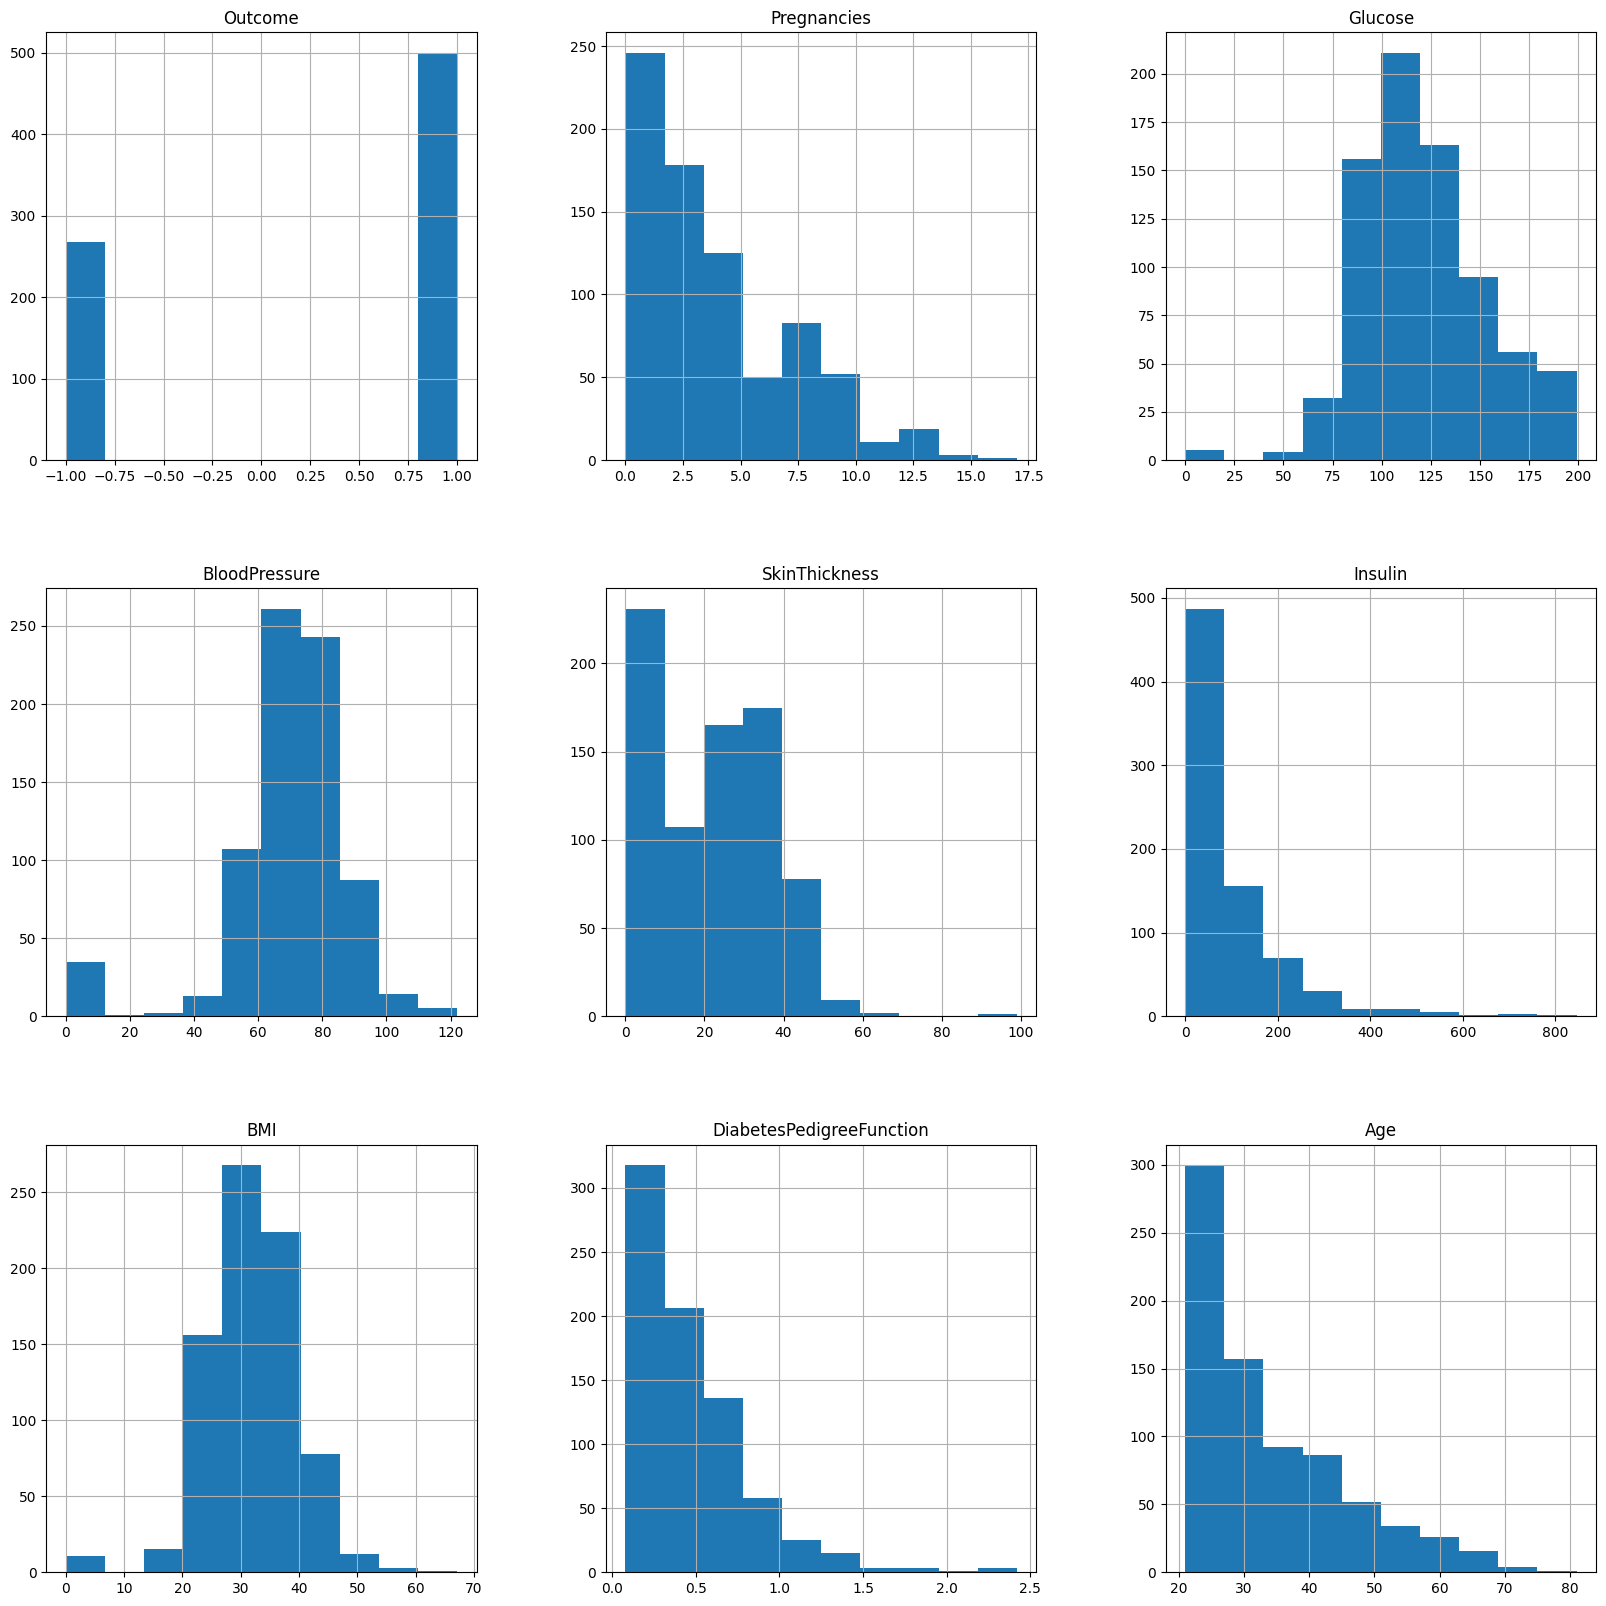

In [4]:
p = diabetes_df.hist(figsize = (20,20))

# Data cleaning and EDA

Following columns should not have zero value:

1. Glucose
2. BloodPressure
3. SkinThickness
4. Insulin
5. BMI

So we replace them with NaN

In [6]:
diabetes_df_cln = diabetes_df.copy(deep=True)

# Probably don't do this

diabetes_df_cln[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_df_cln[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

print(diabetes_df_cln.isnull().sum())

Outcome                       0
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


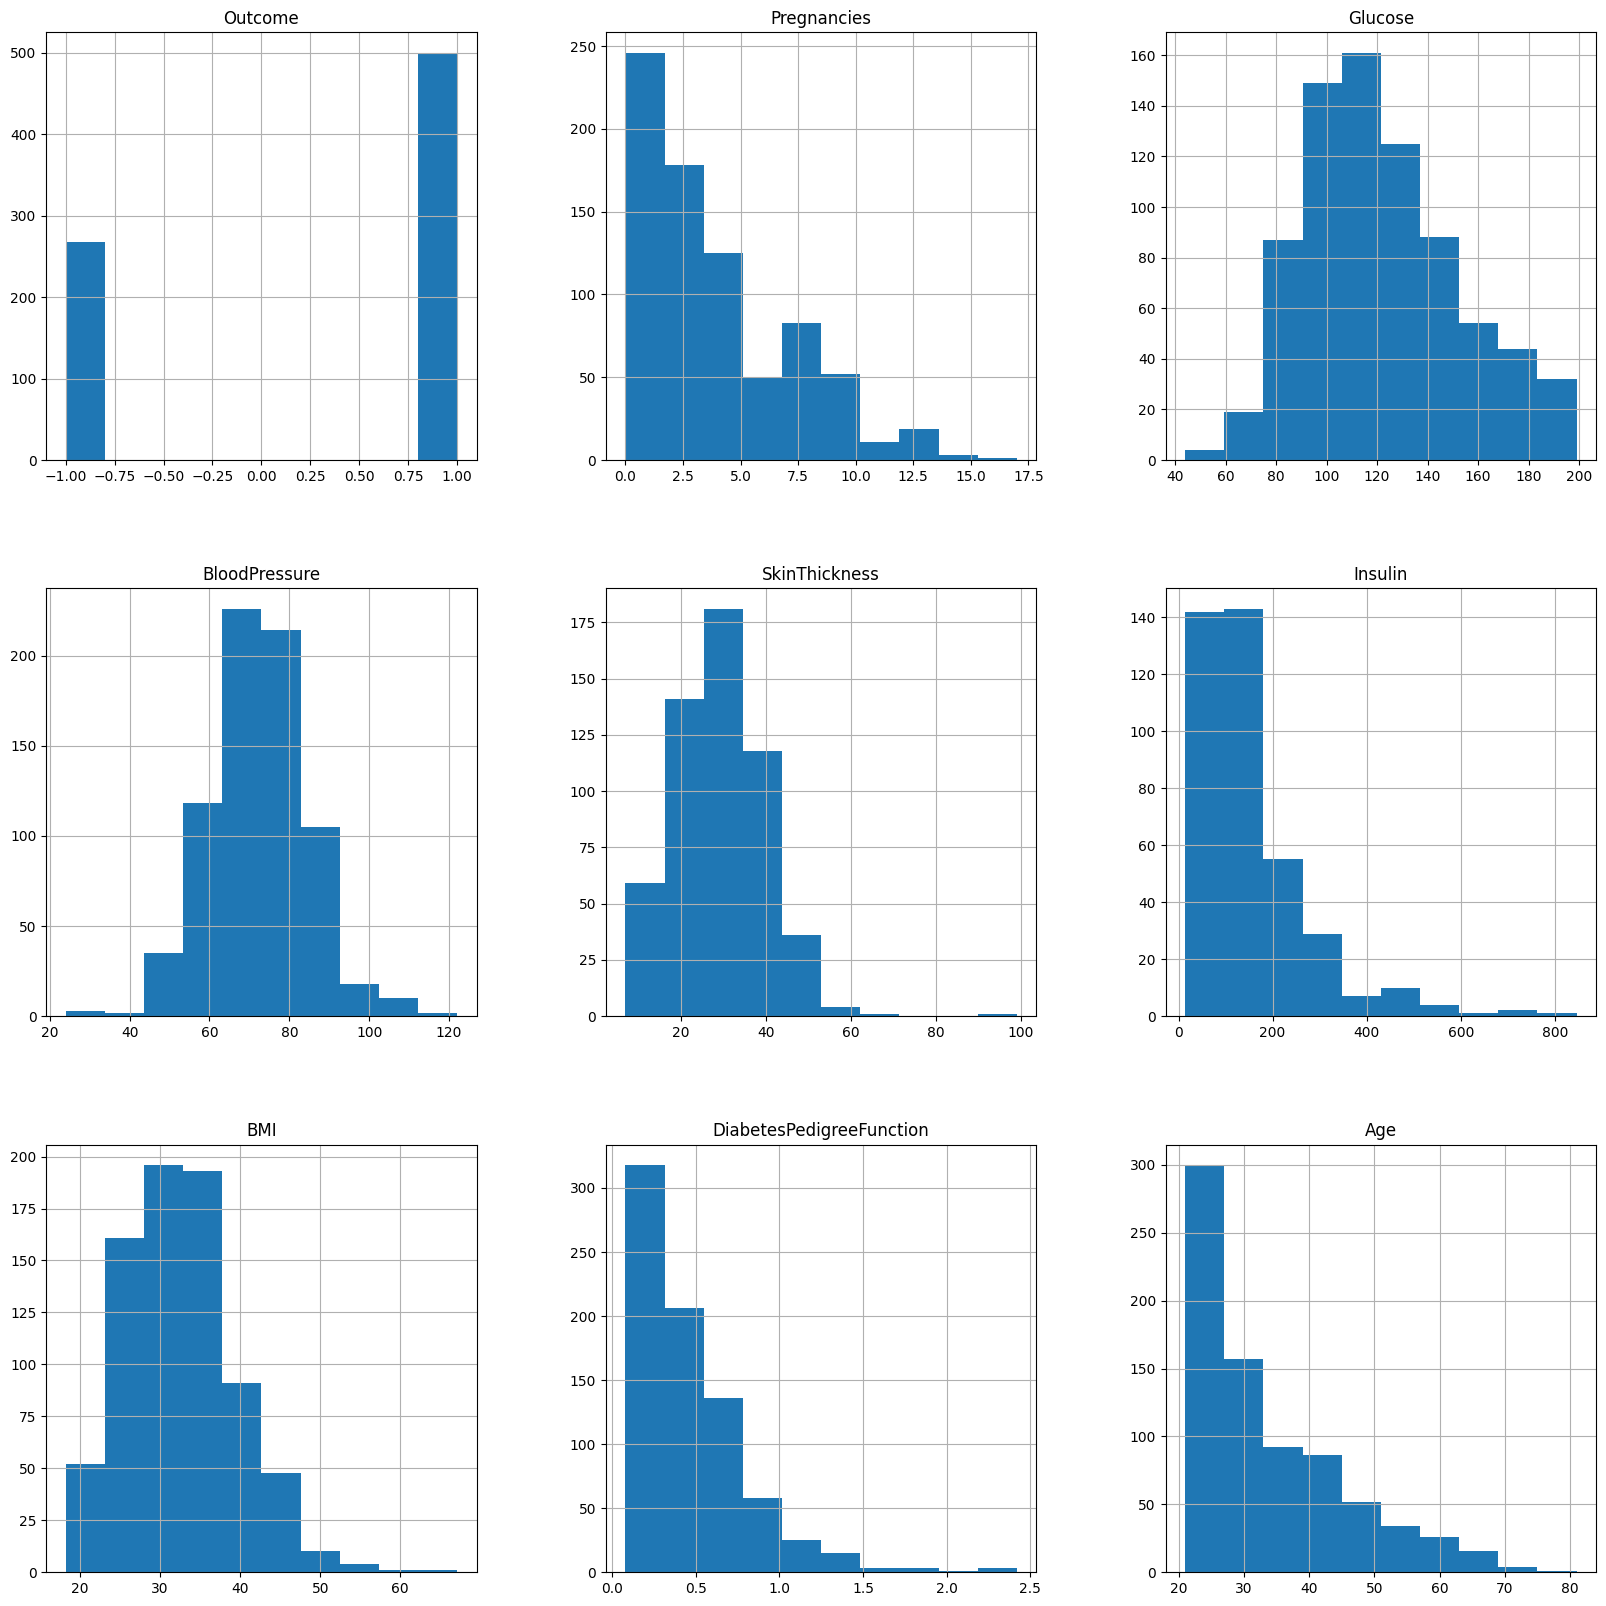

In [7]:
p = diabetes_df_cln.hist(figsize = (20,20))

In [8]:
# Impute the missing values with mean imputation
diabetes_df_cln['Glucose'].fillna(diabetes_df_cln['Glucose'].mean(), inplace = True)
diabetes_df_cln['BloodPressure'].fillna(diabetes_df_cln['BloodPressure'].mean(), inplace = True)
diabetes_df_cln['SkinThickness'].fillna(diabetes_df_cln['SkinThickness'].mean(), inplace = True)
diabetes_df_cln['Insulin'].fillna(diabetes_df_cln['Insulin'].mean(), inplace = True)
diabetes_df_cln['BMI'].fillna(diabetes_df_cln['BMI'].mean(), inplace = True)

print(diabetes_df_cln.isnull().sum())

Outcome                     0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


C:\Users\irfan\AppData\Local\Temp\ipykernel_21088\4050529.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetes_df_cln['Glucose'].fillna(diabetes_df_cln['Glucose'].mean(), inplace = True)
C:\Users\irfan\AppData\Local\Temp\ipykernel_21088\4050529.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

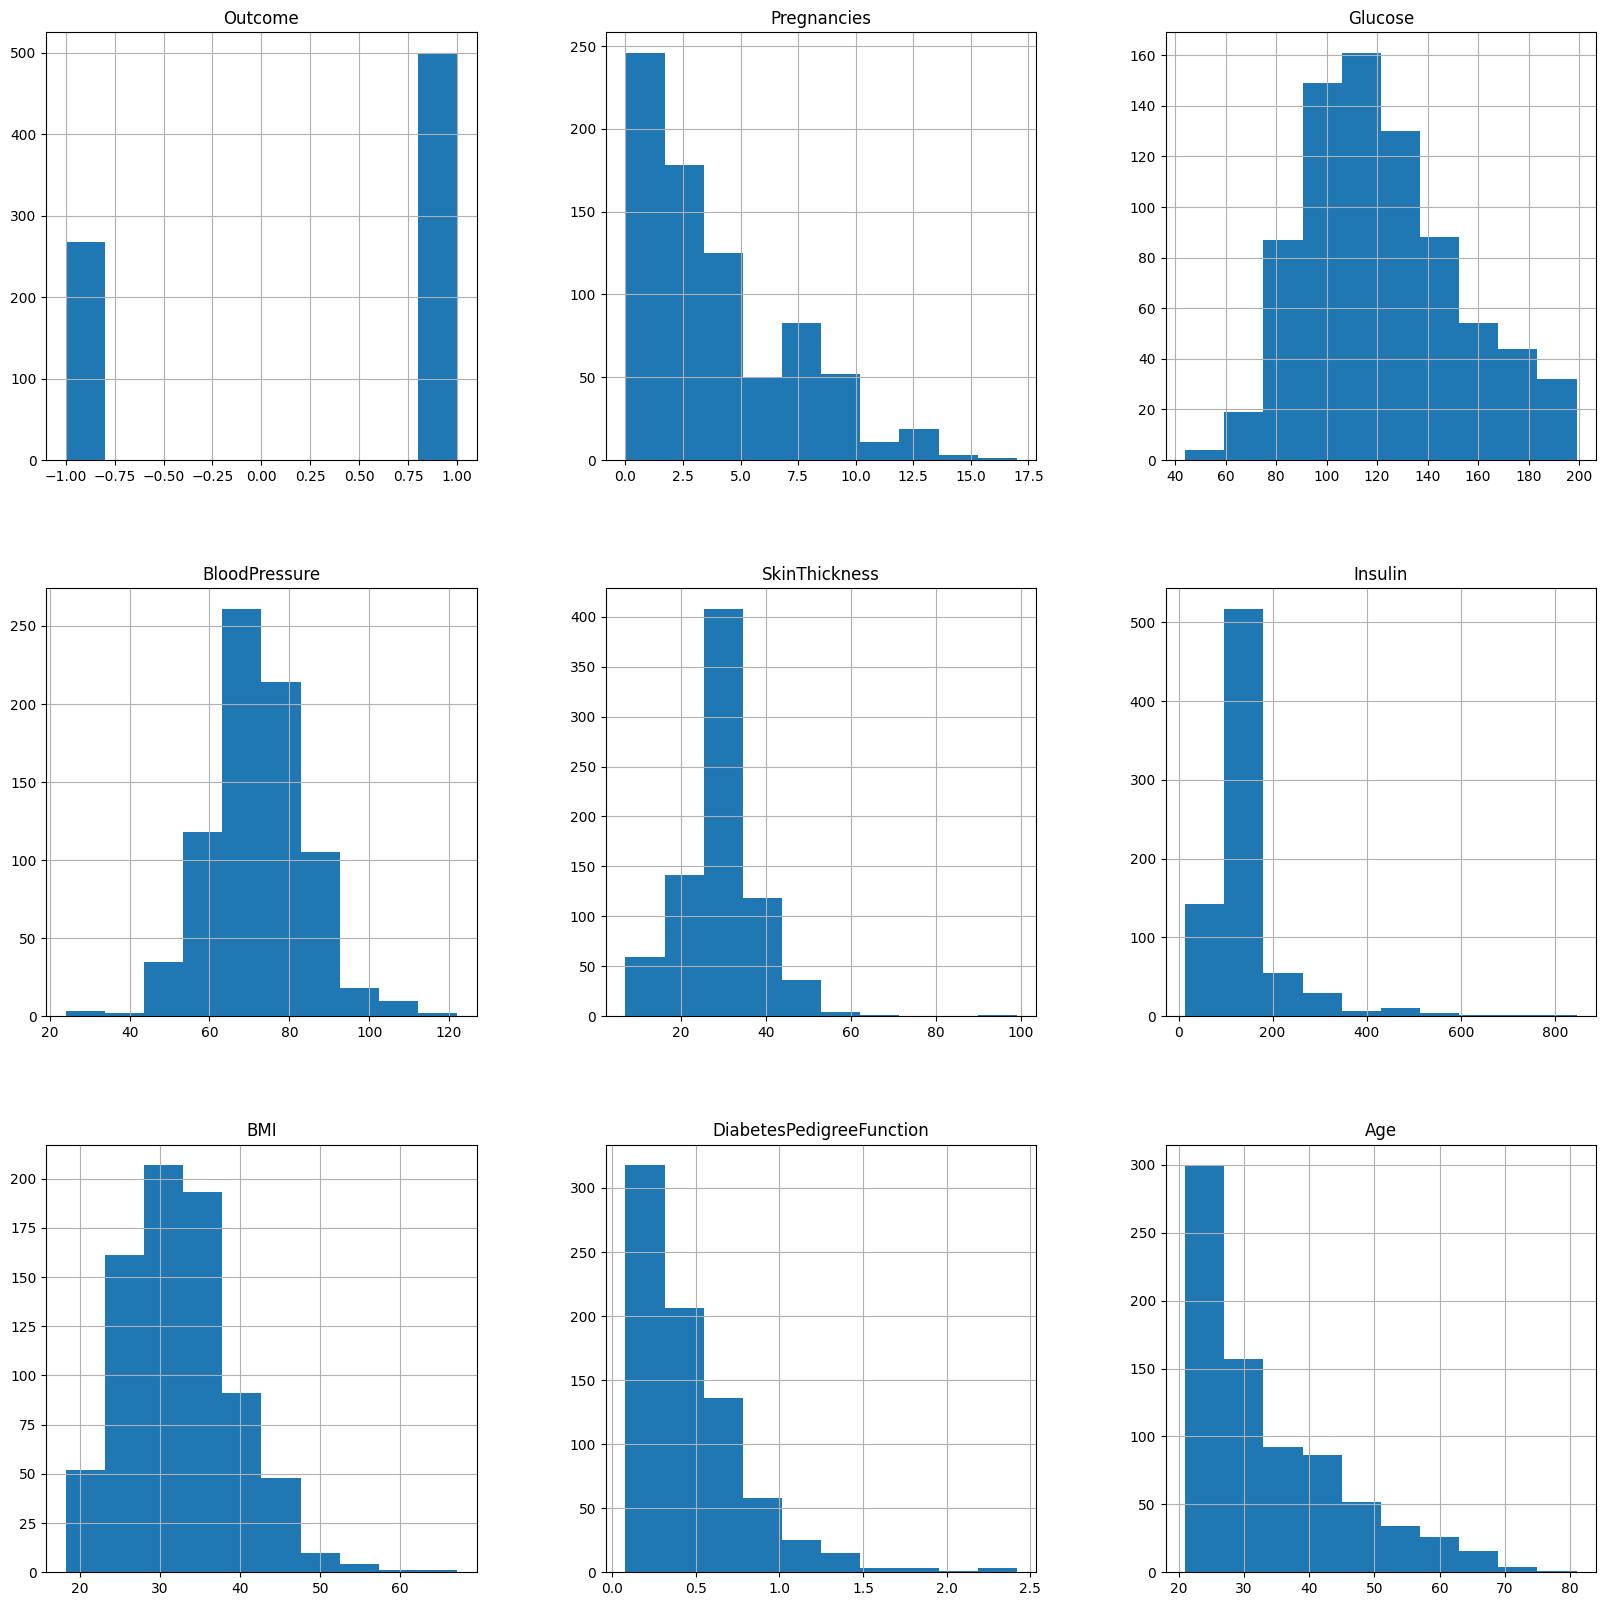

In [9]:
p = diabetes_df_cln.hist(figsize = (20,20))

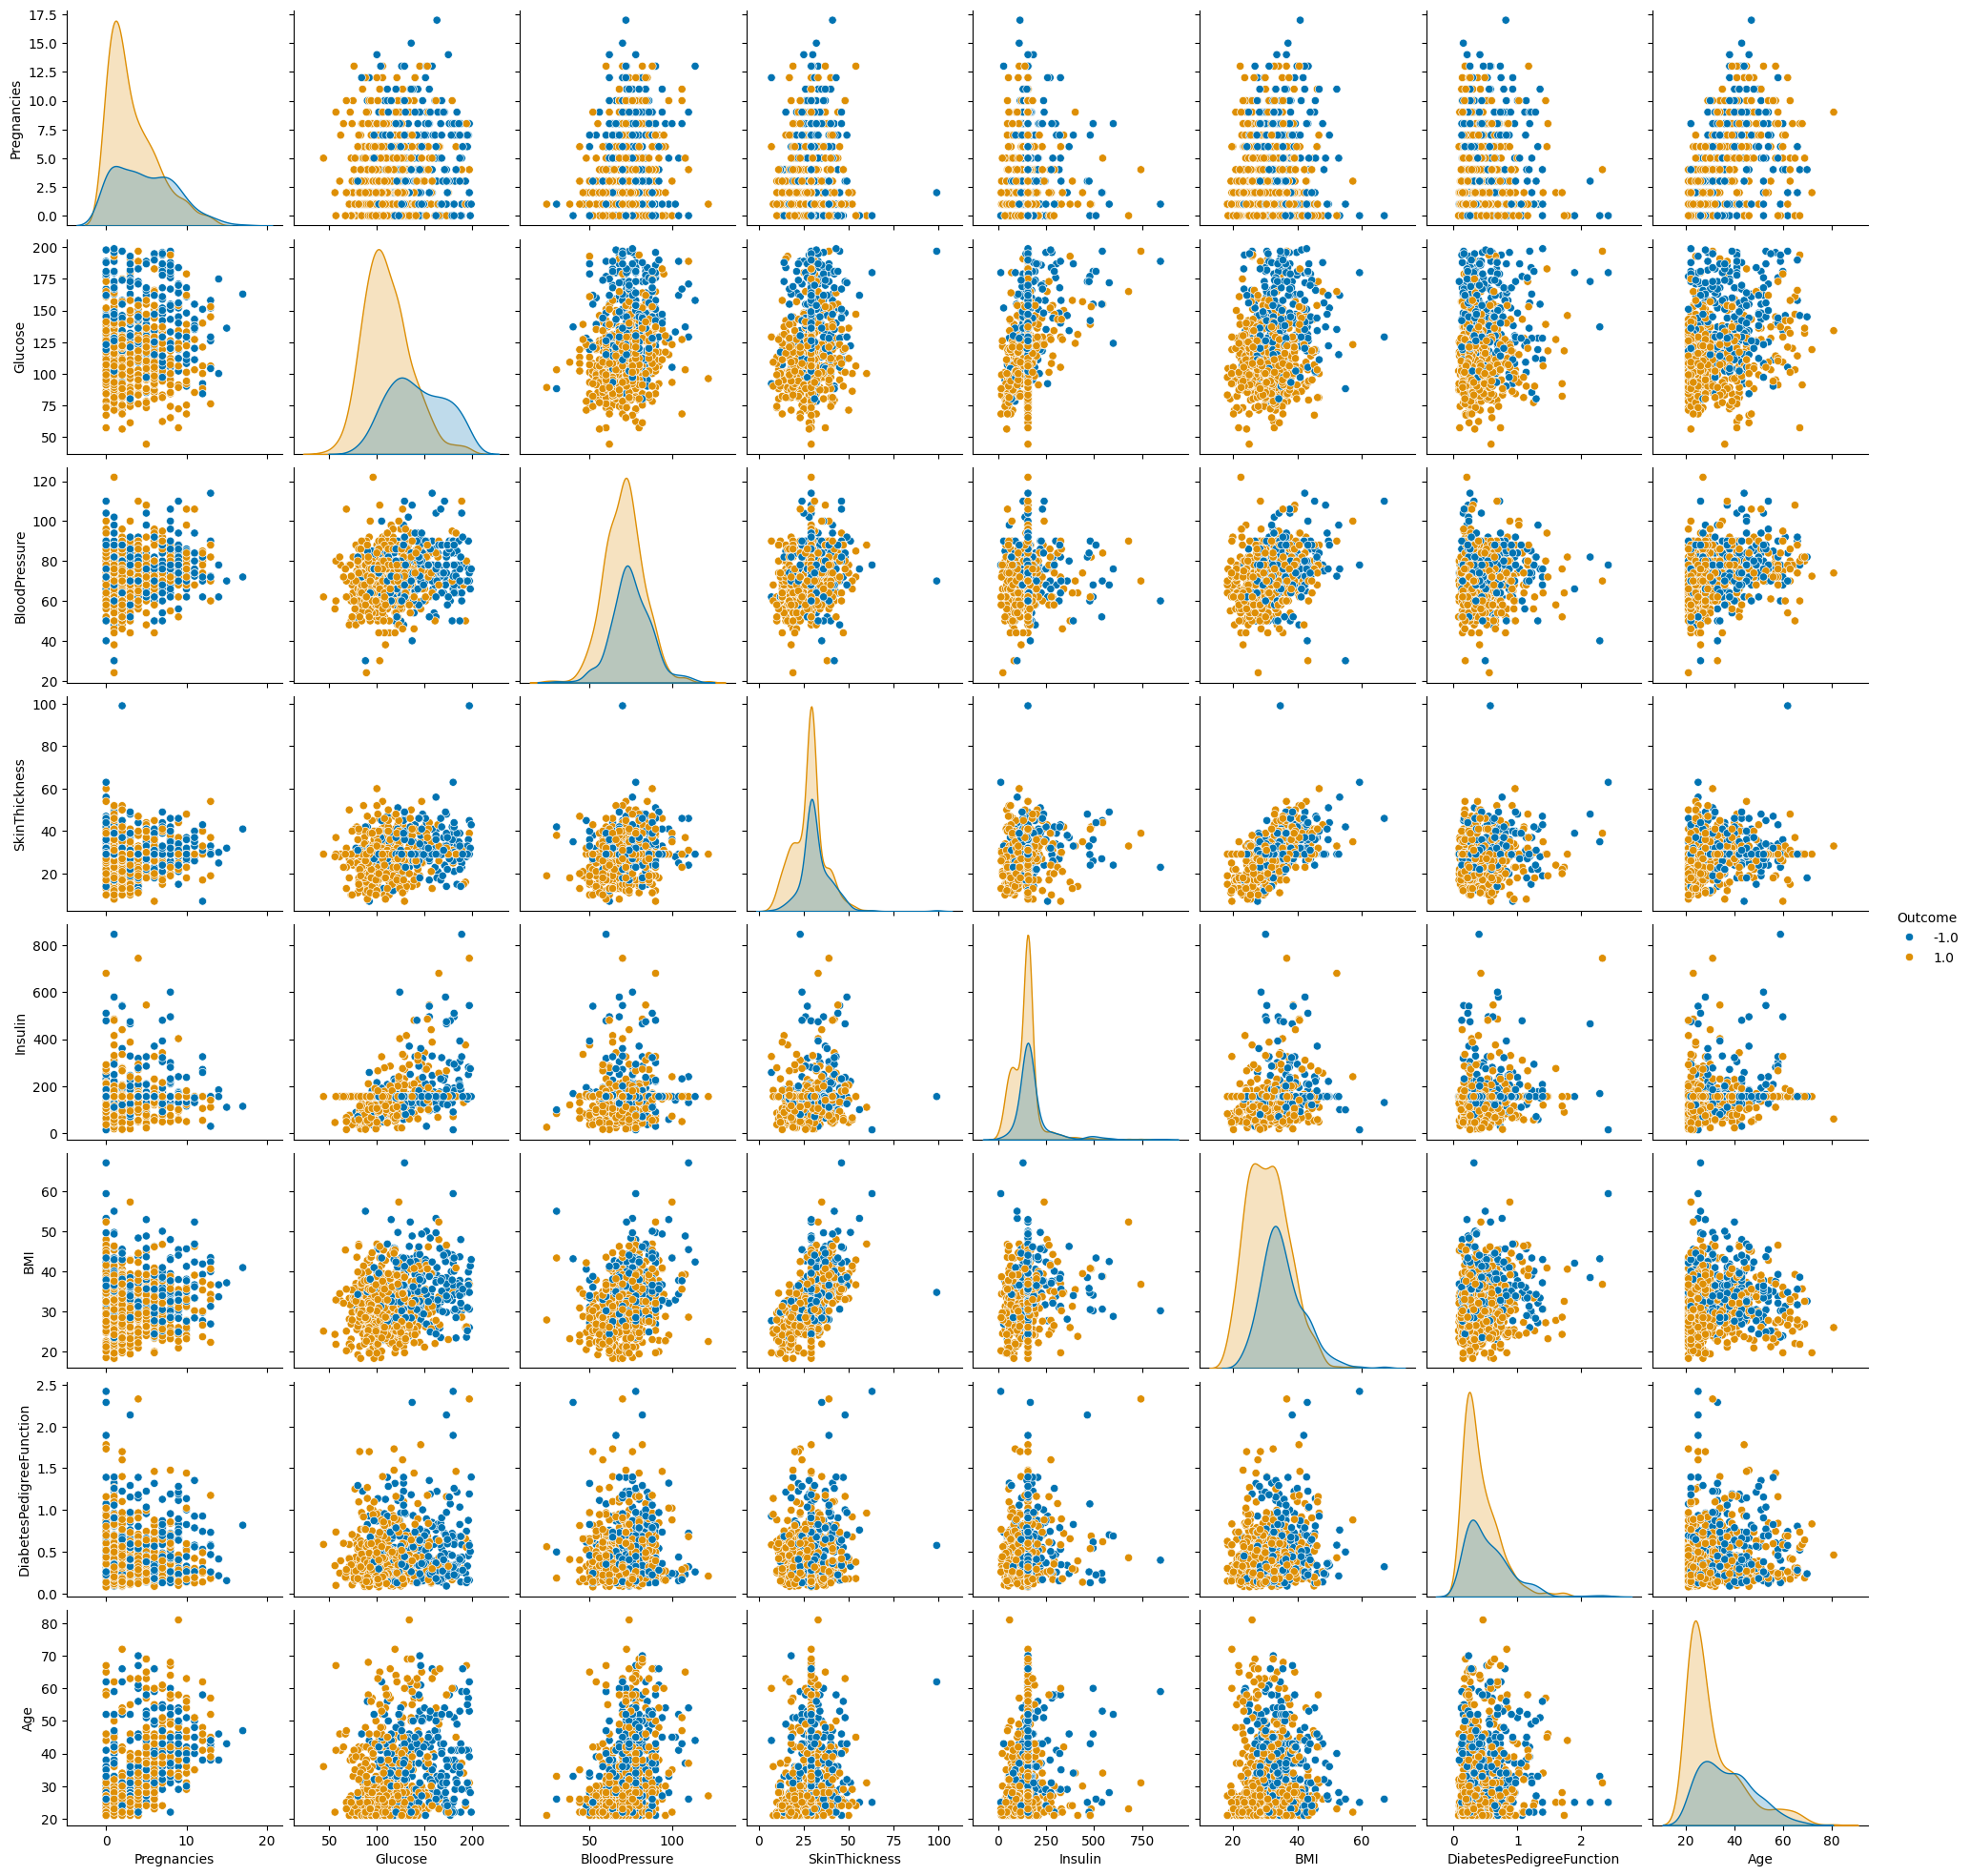

In [10]:
p = sns.pairplot(diabetes_df_cln, hue='Outcome', palette='colorblind')

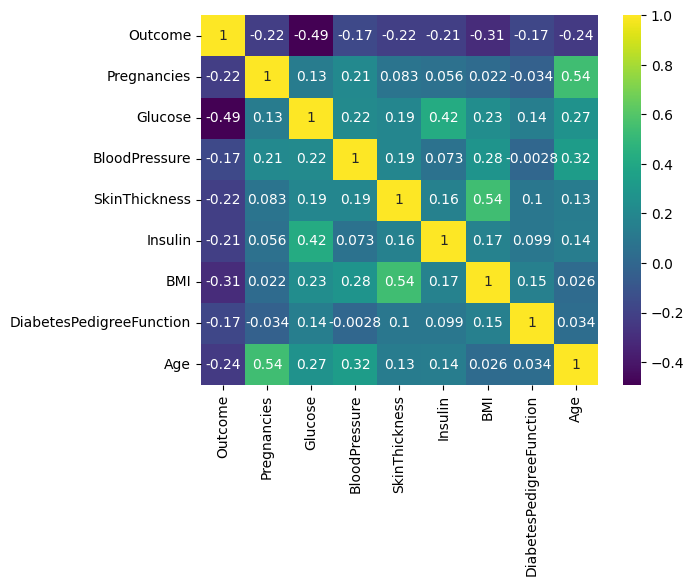

In [11]:
p = sns.heatmap(diabetes_df_cln.corr(), annot=True, cmap='viridis')


# Data scaling

In [12]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(diabetes_df.drop(["Outcome"],axis = 1),),
                  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                           'BMI', 'DiabetesPedigreeFunction', 'Age'])
# X =  pd.DataFrame(sc_X.fit_transform(diabetes_df_cln.drop(["Outcome"],axis = 1),),
#                   columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
#                            'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [13]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103256,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409745,5.484909,-0.020496


# Train test split

In [22]:
y = diabetes_df.Outcome
# y = diabetes_df_cln.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, diabetes_df['Outcome'], test_size = 1/3, 
                                                    random_state = 48, stratify= y)

# Build Perceptron model

In [24]:
y_train = (y_train == 1).astype(float)  # Convert -1 to 0 and keep 1 as 1
y_test = (y_test == 1).astype(float)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
def get_data_loader(X, y, batch_size=64):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset=dataset, batch_size=64, shuffle=True)

train_dataloader = get_data_loader(X_train_tensor, y_train_tensor)

# Single layer Perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        
    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in))
    
# Model, loss function and optimizer
input_dim = X_train.shape[1]
model = SingleLayerPerceptron(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Model training

In [25]:
def train_model(model, train_loader, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            # print(f"y_batch min: {y_batch.min().item()}, y_batch max: {y_batch.max().item()}")
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
        if epoch % 10 == 0:
            print (f'Epoch: [{epoch+1}/{num_epochs}] Loss: {loss.item()}')
    return model

num_epochs = 100

model = train_model(model, train_dataloader, num_epochs, criterion, optimizer)

Epoch: [1/100] Loss: 0.5792833566665649
Epoch: [11/100] Loss: 0.4292621314525604
Epoch: [21/100] Loss: 0.49197590351104736
Epoch: [31/100] Loss: 0.3935796618461609
Epoch: [41/100] Loss: 0.43549424409866333
Epoch: [51/100] Loss: 0.3566688597202301
Epoch: [61/100] Loss: 0.44296595454216003
Epoch: [71/100] Loss: 0.33741843700408936
Epoch: [81/100] Loss: 0.4469115734100342
Epoch: [91/100] Loss: 0.5490657091140747


# Model evaluation

In [26]:
# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).sum() / y_test.shape[0]
    return accuracy.item() * 100

accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 74.61%


# Hyperparameter tuning

The key hyperparameters to tune are:

* Learning rate (`lr`)
* Batch size
* Number of epochs
* Optimizer type (`Adam`, `SGD`, etc.)
* Weight initialisation method

In [27]:
# Hyperparameter values to try
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epoch_nums = [50, 100]
optimizers = ['adam', 'sgd']

# activation? dropout rate?

def get_optimizer(optimizer_type, model, lr):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)

In [28]:
# Track the best model and accuracy
best_accuracy = 0
best_params = {}

# Loop through different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epoch_nums:
            for opt in optimizers:
                # Print current combination of hyperparameters
                print(f'Testing: lr={lr}, batch_size={batch_size}, epochs={num_epochs}, optimizer={opt}')
                
                # Prepare DataLoader
                train_loader = get_data_loader(X_train_tensor, y_train_tensor, batch_size)
                
                # Initialize model and optimizer
                model = SingleLayerPerceptron(X_train.shape[1])
                optimizer = get_optimizer(opt, model, lr)

                # Train the model
                model = train_model(model, train_loader, num_epochs, criterion, optimizer)

                # Evaluate the model
                accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

                # Check if this is the best model
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs,
                        'optimizer': opt
                    }

                print(f'Accuracy: {accuracy:.2f}%')

# Print the best hyperparameter combination
print(f'Best accuracy: {best_accuracy:.2f}%')
print(f'Best hyperparameters: {best_params}')


Testing: lr=0.01, batch_size=16, epochs=50, optimizer=adam
Epoch: [1/50] Loss: 0.6685092449188232
Epoch: [11/50] Loss: 0.4375155568122864
Epoch: [21/50] Loss: 0.42940598726272583
Epoch: [31/50] Loss: 0.41129475831985474
Epoch: [41/50] Loss: 0.5038814544677734
Accuracy: 74.61%
Testing: lr=0.01, batch_size=16, epochs=50, optimizer=sgd
Epoch: [1/50] Loss: 0.7824933528900146
Epoch: [11/50] Loss: 0.6917526125907898
Epoch: [21/50] Loss: 0.6322656869888306
Epoch: [31/50] Loss: 0.5431177616119385
Epoch: [41/50] Loss: 0.627716064453125
Accuracy: 75.39%
Testing: lr=0.01, batch_size=16, epochs=100, optimizer=adam
Epoch: [1/100] Loss: 0.8282727599143982
Epoch: [11/100] Loss: 0.5068265199661255
Epoch: [21/100] Loss: 0.42672038078308105
Epoch: [31/100] Loss: 0.4507218897342682
Epoch: [41/100] Loss: 0.42344170808792114
Epoch: [51/100] Loss: 0.5594063401222229
Epoch: [61/100] Loss: 0.4703490734100342
Epoch: [71/100] Loss: 0.5321294665336609
Epoch: [81/100] Loss: 0.5109602808952332
Epoch: [91/100] Loss